# Batch effects in metabolite data for segregants

One concern with the experimental methodology is how the samples were measured. Each strain and replicate was measured in an analytical batch. This could lead to significant biases within and across batches that would lead to problems with QTL mapping.

Here I check the data for evidence of batch effects using the analytical batch identifications I recieved from Nicole

In [1]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
#library(FactoMineR);
library(missMDA);
options(repr.plot.width = 6)
options(repr.plot.height = 5)
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(pheatmap);
library(parallel);
options(mc.cores = 24);
library(stringr);
library(RColorBrewer);
# load parental data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

Loading required package: FactoMineR
Loading required package: mice
Loading required package: Rcpp
mice 2.25 2015-11-09
Loading required package: mvtnorm

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#head(endometabolite)
# for these anlysese only keep relative time format
endometabolite = endometabolite %>% filter(time_format=="relative")

In [7]:
head(endometabolite)

,strain,metabolite,replicate,time_format,time,value,value.log2,relative.log2,derivative.log2,cellconc,biovol,singlecellvol,peakarea,batch
1,01B,AKG,1,relative,1,64.62115,6.036089,1,NA,NA,NA,NA,NA,dM1
2,01B,AKG,1,relative,2,75.42941,6.256056,1.036442,0.219967,NA,NA,NA,NA,dM1
3,01B,AKG,1,relative,3,46.9538,5.583573,0.9250316,-0.6724827,NA,NA,NA,NA,dM1
4,01B,AKG,1,relative,4,57.4146,5.868257,0.9721952,0.2846837,NA,NA,NA,NA,dM1
5,01B,AKG,2,relative,1,65.08506,6.046252,1,NA,NA,NA,NA,NA,dM1
6,01B,AKG,2,relative,2,61.94676,5.97606,0.9883908,-0.07019202,NA,NA,NA,NA,dM1


In [8]:
min(endometabolite$value[endometabolite$value>0], na.rm=T)

[1] 0.09822669

In [11]:
(max(endometabolite$value[endometabolite$value>0], na.rm=T))

[1] 84691.99

##  All metabolites, time points

In [3]:
p <- ggplot(endometabolite, aes(x = batch, y = value.log2)) +
    geom_boxplot()

Warning message:
: Removed 1953 rows containing non-finite values (stat_boxplot).

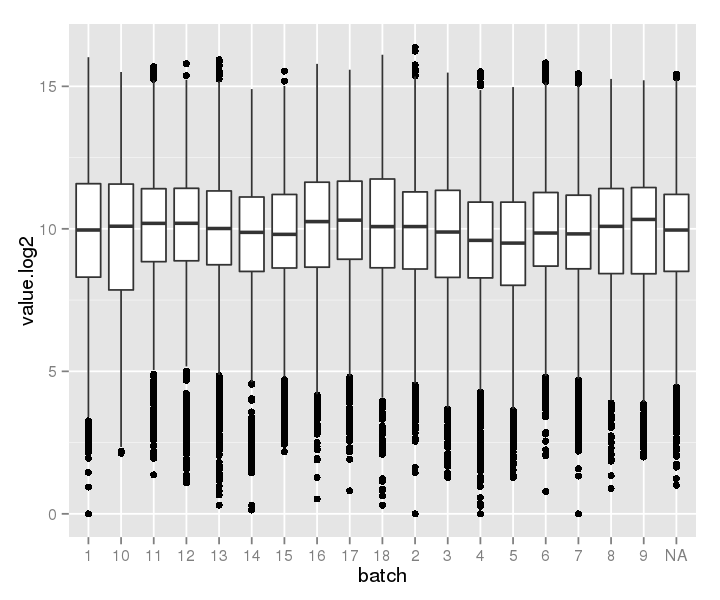

In [4]:
p

### Side Note: What are metabolites/timepoints without batch label?

In [4]:
#unique(endometabolite[is.na(endometabolite$batch),"strain"])

,strain


Contacted Nicole to see if I can get the correct batch annotations for these strains.

Problem solved. 16.03.2016. Have complete mappings.

## Per metabolite

In [46]:
options(repr.plot.width = 8)
options(repr.plot.height = 15)
p2 <- ggplot(endometabolite, aes(x = batch, y = value.log2)) +
    geom_boxplot() + facet_wrap(~ metabolite, ncol = 3)

Warning message:
: Removed 50 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 58 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 63 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 110 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 54 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 42 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 242 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 46 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 61 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 58 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 47 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 46 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 47 rows containing non-

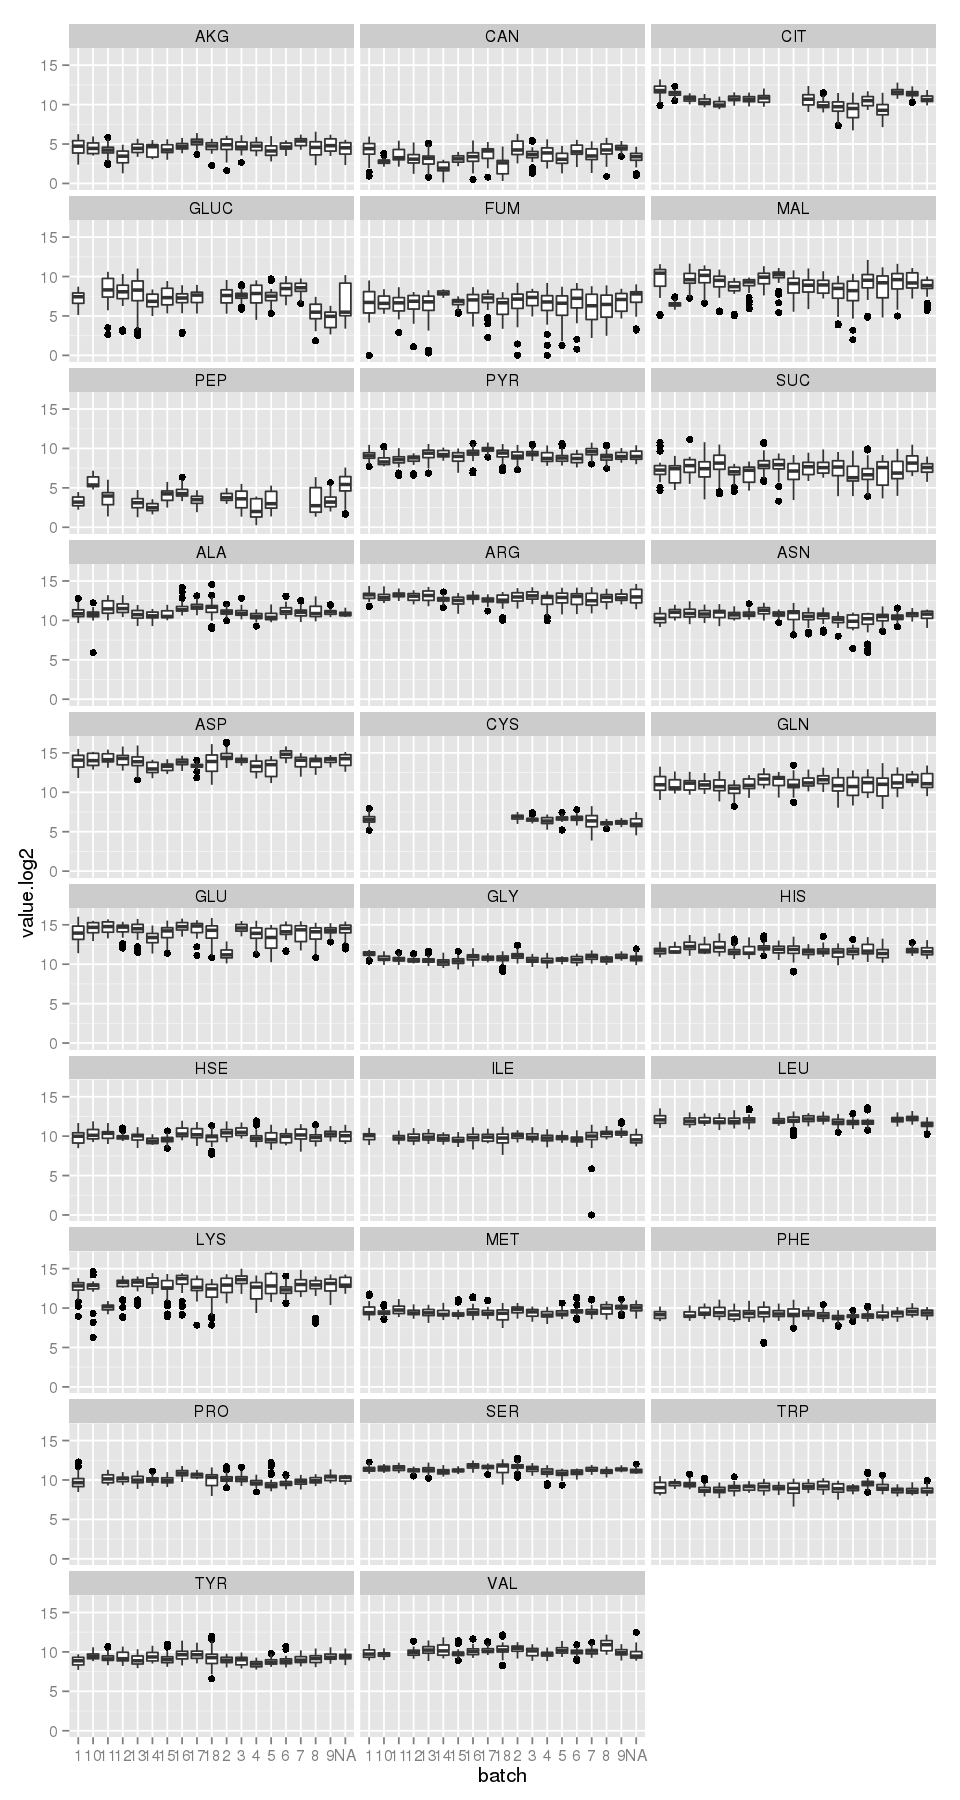

In [47]:
p2

# Check for batch effect with PCA 

In [5]:
c25 <- c("dodgerblue2","#E31A1C", # red
                "green4",
                "#6A3D9A", # purple
                "#FF7F00", # orange
                "black","gold1",
                "skyblue2","#FB9A99", # lt pink
                "palegreen2",
                "#CAB2D6", # lt purple
                "#FDBF6F", # lt orange
                "gray70", "khaki2",
                "maroon","orchid1","deeppink1","blue1","steelblue4",
                "darkturquoise","green1","yellow4","yellow3",
                "darkorange4","brown")

In [15]:
mm = acast(endometabolite, strain ~ metabolite + time, fun.aggregate = mean, value.var = "value.log2")
#mm = acast(endometabolite, strain ~ time, fun.aggregate = mean, value.var = "value.log2")

# estimate missing values with missMDA
nb = missMDA::estim_ncpPCA(mm, ncp.min = 0, ncp.max = 5, method.cv="Kfold")

  |======================================================================| 100%


In [11]:
mm.impute = missMDA::imputePCA(mm, ncp = nb$ncp)

In [12]:
#batchpca = PCA(mm.impute$complete)
allBatches = levels(endometabolite$batch)
b2c = c25[1:length(allBatches)]
names(b2c) = allBatches

In [13]:
batchLabel = endometabolite_nobatchna %>% group_by(strain) %>% do({
    thisstrain = unique(.$strain)
    thisbatch = unique(.$batch)
    thiscolor = try({b2c[thisbatch]})
    if (class(thiscolor)=="try-error") {
        thiscolor = "brown"
    }
    return(data.frame(thisstrain,thisbatch,thiscolor))
})

In [14]:
batchpca = PCA(mm.impute$completeObs, graph = FALSE)

dev.new(): using pdf(file="Rplots100.pdf")
dev.new(): using pdf(file="Rplots101.pdf")


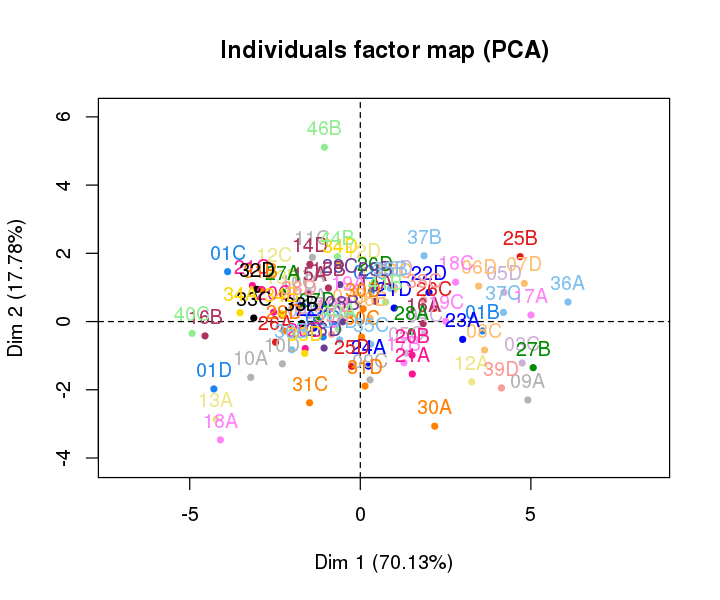

In [68]:
plot(batchpca, col.ind = batchLabel$thiscolor)